<h1>Baseball Pitching Regression Model</h1>

#### Index
<ul>
<a href="#Intro">Introduction</a><br>
<a href="#Import">Import the Data</a><br>
<a href="#Visualize">Visualize the Data</a><br>
<a href="#Clean">Clean up the Data</a><br>    
<a href="#Pick">Pick Features to Work With</a><br>
<a href="#Set">Set the Training and Test Data Set</a><br>
<a href="#Run">Run Regression Algorithms</a><br>
<a href="#Pickle">Pickle the Models</a><br>
</ul>

### <a id="Intro">Introduction:</a> <br>

My original goal for this project was to see if I could predict a pitchers ERA for the next seaosn based off of the statistics they produced over the past couple of seasons. That turned into a much bigger and more complicated problem than I originally expected. I changed my project to try and predict what would be the best statistic in order to see if a pitcher has a good ERA or not.

### <a id="Import">Import the Data:</a> <br>
First we need to import our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
data = pd.read_csv('Pitching.csv', index_col='playerID', parse_dates=True)

Print out the beginning and the end of our data to see what it looks like

In [2]:
data.head()

,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,
bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,...,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,...,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,...,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,...,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,...,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [3]:
data.tail()

,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,
youngch03,2017,1,KCA,AL,0,0,14,2,0,0,...,2.0,1,1.0,0,148.0,5,27,0.0,0.0,3.0
zastrro01,2017,1,CHN,NL,0,0,4,0,0,0,...,0.0,0,1.0,0,62.0,0,13,0.0,0.0,3.0
zieglbr01,2017,1,MIA,NL,1,4,53,0,0,0,...,6.0,1,6.0,0,211.0,21,29,3.0,0.0,10.0
zimmejo02,2017,1,DET,AL,8,13,29,29,0,0,...,2.0,3,7.0,0,713.0,0,111,3.0,8.0,19.0
zychto01,2017,1,SEA,AL,6,3,45,0,0,0,...,3.0,1,5.0,1,173.0,7,12,1.0,2.0,5.0


### <a id="Visualize">Visualize the Data:</a> <br>

Next we will look at plotting some of our data to give us a visual overview

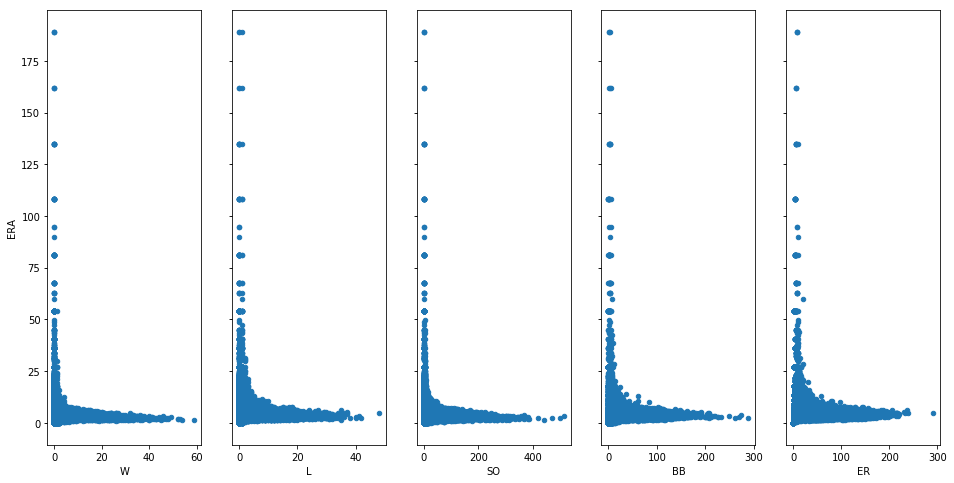

In [4]:
fig, axs = plt.subplots(1, 5, sharey=True)
data.plot(kind='scatter', x='W', y='ERA', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='L', y='ERA', ax=axs[1])
data.plot(kind='scatter', x='SO', y='ERA', ax=axs[2])
data.plot(kind='scatter', x='BB', y='ERA', ax=axs[3])
data.plot(kind='scatter', x='ER', y='ERA', ax=axs[4])

Explore some of the data that I think will be useful. Let's start off with ERA, wins and losses

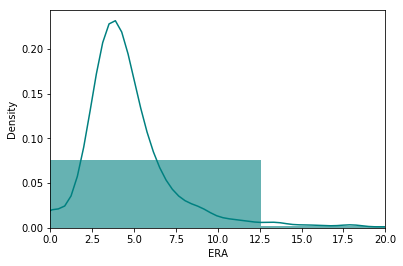

In [5]:
ax = data["ERA"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["ERA"].plot(kind='density', color='teal')
ax.set(xlabel='ERA')
plt.xlim(0,20)
plt.show()

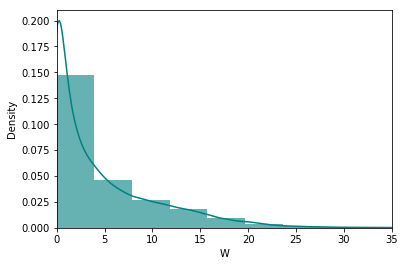

In [6]:
ax = data["W"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["W"].plot(kind='density', color='teal')
ax.set(xlabel='W')
plt.xlim(0,35)
plt.show()

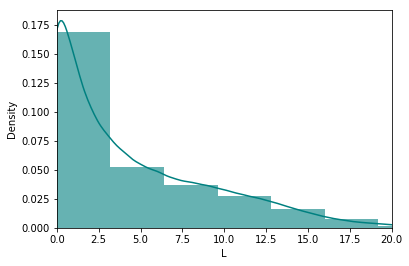

In [7]:
ax = data["L"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["L"].plot(kind='density', color='teal')
ax.set(xlabel='L')
plt.xlim(0,20)
plt.show()

Lets us also check to see what the mean and median of the ERA is with just our default data

In [8]:
# mean era
print('The mean of "ERA" is %.2f' %(data["ERA"].mean(skipna=True)))
# median era
print('The median of "ERA" is %.2f' %(data["ERA"].median(skipna=True)))

The mean of "ERA" is 5.08
The median of "ERA" is 4.14


### <a href="#Clean">Clean up the Data</a><br>

Earlier in our head and tail, there was some null data. Lets see what exactly we have for null values

In [9]:
data.isnull().sum()

yearID        0
stint         0
teamID        0
lgID        132
W             0
L             0
G             0
GS            0
CG            0
SHO           0
SV            0
IPouts        0
H             0
ER            0
HR            0
BB            0
SO            0
BAOpp      2717
ERA          90
IBB       14578
WP            0
HBP         734
BK            0
BFP           6
GF            0
R             0
SH        19187
SF        19187
GIDP      20324
dtype: int64

We have some null values that we don't need for pitching such as SF (sacrifice fly), SH (sacrifice hit), GIDP (ground into double play), HBP (hit by pitch), IBB (intentional base by balls), and BAOpp (batting average opponent). The only one that might be somewhat relevant is BAOpp. That feature might help us determine whether a pitcher has a good ERA or not, but we will get rid of it for now because of the amount of missing values.

In [10]:
data = data.drop(columns=['GIDP', 'SF', 'SH', 'HBP', 'IBB', 'BAOpp'])

In [11]:
data.isnull().sum()

yearID      0
stint       0
teamID      0
lgID      132
W           0
L           0
G           0
GS          0
CG          0
SHO         0
SV          0
IPouts      0
H           0
ER          0
HR          0
BB          0
SO          0
ERA        90
WP          0
BK          0
BFP         6
GF          0
R           0
dtype: int64

We do have some stats that we will need to be filled in, like ERA (which all pitches should have), league ID (no league in early baseball), and BFP (batters faced by pitcher). For ERA and BFP it makes sense to just fill in those values with the mean. For leagueID, it doesn't make sense to give it a mean value because a string can't ahve a mean value. I will just fill the empty value with "Old League". Now we should have zero null values in our data set going forward, making it easier to work with.

In [12]:
data['ERA']= data['ERA'].fillna(data['ERA'].mean())
data['BFP']= data['BFP'].fillna(data['BFP'].mean())
data['lgID']= data['lgID'].fillna('Old League')

In [13]:
data.isnull().sum()

yearID    0
stint     0
teamID    0
lgID      0
W         0
L         0
G         0
GS        0
CG        0
SHO       0
SV        0
IPouts    0
H         0
ER        0
HR        0
BB        0
SO        0
ERA       0
WP        0
BK        0
BFP       0
GF        0
R         0
dtype: int64

Our prediction can be skewed by players that haven't played in enough games. We only want to use pitchers who have pitched in 10 or more games. This will get rid of a lot a relievers that don't start enough games to provide relevant data.

In [14]:
current_data = data.loc[data['G'] > 10]
current_data.shape

(30988, 23)

We don't have any need for strings. Delete string values from the data set.

In [15]:
current_data.drop('teamID', axis=1, inplace=True)
current_data.drop('lgID', axis=1, inplace=True)

C:\Users\ndbie\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Lets revisualize the relationship between the features and the response using scatterplots

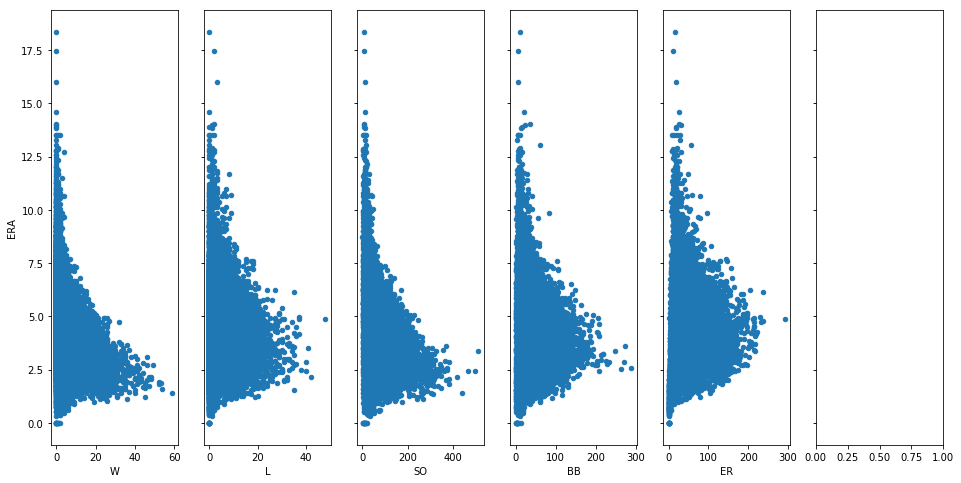

In [16]:
fig, axs = plt.subplots(1, 6, sharey=True)
current_data.plot(kind='scatter', x='W', y='ERA', ax=axs[0], figsize=(16, 8))
current_data.plot(kind='scatter', x='L', y='ERA', ax=axs[1])
current_data.plot(kind='scatter', x='SO', y='ERA', ax=axs[2])
current_data.plot(kind='scatter', x='BB', y='ERA', ax=axs[3])
current_data.plot(kind='scatter', x='ER', y='ERA', ax=axs[4])

And again, lets see how the ERA, wins and loss histograms have changed.

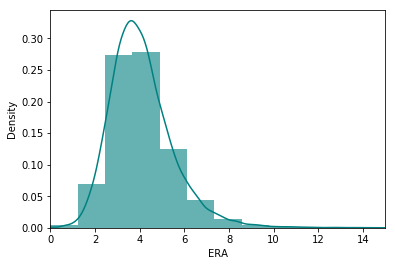

In [17]:
ax = current_data["ERA"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
current_data["ERA"].plot(kind='density', color='teal')
ax.set(xlabel='ERA')
plt.xlim(0,15)
plt.show()

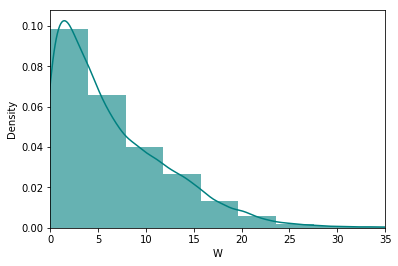

In [18]:
ax = current_data["W"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
current_data["W"].plot(kind='density', color='teal')
ax.set(xlabel='W')
plt.xlim(0,35)
plt.show()

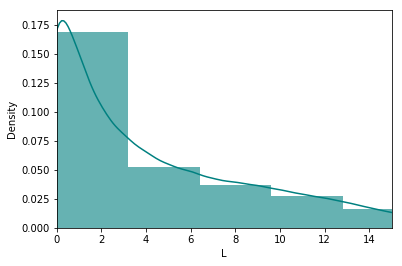

In [19]:
ax = data["L"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
data["L"].plot(kind='density', color='teal')
ax.set(xlabel='L')
plt.xlim(0,15)
plt.show()

And lastly, lets see how the mean and median ERA have also changed since removing some pitchers.

In [20]:
# mean era
print('The mean of "ERA" is %.2f' %(current_data["ERA"].mean(skipna=True)))
# median era
print('The median of "ERA" is %.2f' %(current_data["ERA"].median(skipna=True)))

The mean of "ERA" is 4.08
The median of "ERA" is 3.90


### <a id="Pick">Pick Features to Work With:</a> <br>

I'm only going to be selecting the features that I think are most relevant when it comes to predicting whether you will have a good ERA or not. These will be wins, losses, walks, striekouts and earned runs. My prediction is that if you have more wins, less losses, less walks, more strikeouts, and less earned runs, you will have a lower ERA. This isn't always going to be necessarily true however. A pitcher could only give up 2 runs a game, but never get run support from his team. This would lead him to having a lot of losses even with low earned runs. The opposite could also be true. A player could give up a lot of runs, but have a team that also gives a lot of run support, meaning he wins even with a high earned run statistic. 

In [21]:
cols = ["W","L","BB","SO","ER"] 
X = current_data[cols]
y = current_data['ERA'].astype(int)
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs')
# create the RFE model and select 8 attributes
rfe = RFE(model, 5)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

C:\Users\ndbie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Selected features: ['W', 'L', 'BB', 'SO', 'ER']


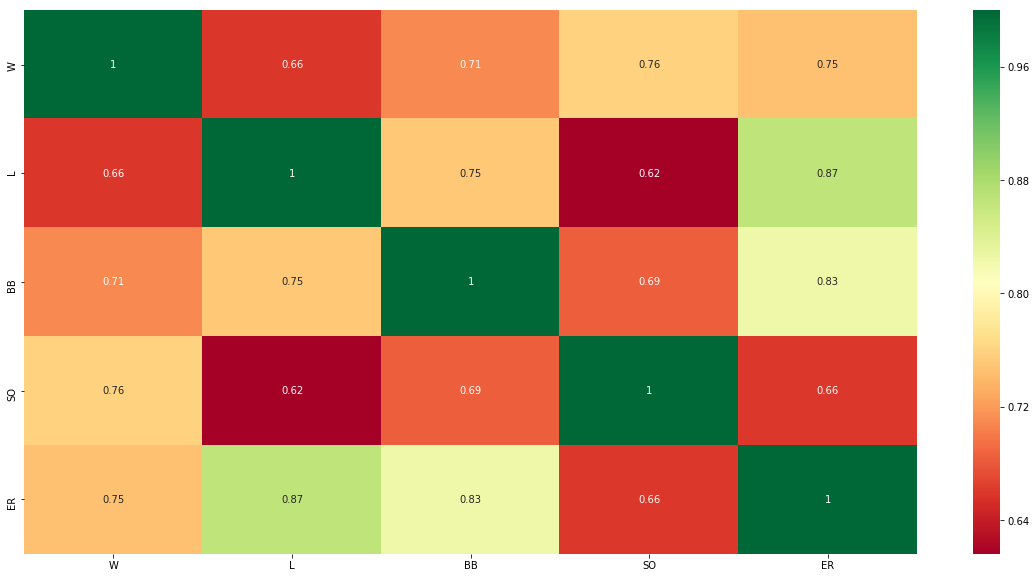

In [22]:
Selected_features = ["W","L","BB","SO","ER"] 
X = current_data[Selected_features]

plt.subplots(figsize=(20, 10))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

### <a href="#Set">Set the Training and Test Data Set</a><br>

Now we will start with creating the linear regression model.

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24790, 5)
(6198, 5)
(24790,)
(6198,)


In [24]:
X_train.shape

(24790, 5)

In [25]:
y_train.shape

(24790,)

### <a href="#Run">Run the Regression Algorithms</a><br>

Then we will apply some logistic regression techniques to run a train and make a prediction.

<b>SGD Regressor</b>

In [26]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, penalty=None, eta0=0.25, random_state=42, learning_rate='optimal')
sgd_reg.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.25, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [27]:
prediction = sgd_reg.predict(X_test)
sgd_reg_X_test = X_test
# Calculate the absolute errors
errors = abs(prediction - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print("Mean Squared Error:", mean_squared_error(y_test, prediction))

Mean Absolute Error: 950916839835.24
Mean Squared Error: 1.7957848972916214e+24


<b>Grid Search</b>

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
# try 36 (3×3×4) combinations of hyperparameters
    {'eta0': [0.2, 0.25, 0.5],
    'learning_rate': ['constant','optimal','invscaling'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    },
]

grid_search = GridSearchCV(sgd_reg, param_grid, cv=5,
scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.25, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'eta0': [0.2, 0.25, 0.5], 'learning_rate': ['constant', 'optimal', 'invscaling'], 'penalty': ['l2', 'l1', 'elasticnet', 'none']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
grid_search.best_params_

{'eta0': 0.2, 'learning_rate': 'optimal', 'penalty': 'l2'}

In [30]:
grid_search.best_estimator_

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.2, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [31]:
prediction = grid_search.predict(X_test)
grid_search_X_test = X_test
# Calculate the absolute errors
errors = abs(prediction - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print("Mean Squared Error:", mean_squared_error(y_test, prediction))

Mean Absolute Error: 1795332449008.98
Mean Squared Error: 5.530789109647266e+24


<b>Random Forest</b>

In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
rf_X_test = X_test
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print("Mean Squared Error:", mean_squared_error(y_test, predictions))

Mean Absolute Error: 0.64
Mean Squared Error: 0.8506513387565784


### <a href="#Pickle">Pickle the Models</a><br>

Next we will pickle the models for use in our Flash Application hosted on Google Cloud

In [34]:
from sklearn.externals import joblib

joblib.dump(sgd_reg, "sgd_regressor.pkl")
joblib.dump(grid_search, "grid_search.pkl")
joblib.dump(rf, "random_forest.pkl")

joblib.dump(sgd_reg_X_test, "sgd_reg_X_test.pkl")
joblib.dump(grid_search_X_test, "grid_search_X_test.pkl")
joblib.dump(rf_X_test, "rf_X_test.pkl")

['rf_X_test.pkl']